# Analysis on predictive models for daily stock volume


In [ ]:
TODO - CAN TIDY THIS UP AND MAKE NOTES CONSISTENT

SUMMARY - ABLE TO FIT ARMA MODEL WHERE AR(1) TERM IS PERCENTAGE ERROR - PERFORMS BETTER THAN ADV30 AND MDV5

In [210]:
# setup
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from datetime import datetime, timedelta

from ipywidgets import IntProgress
from IPython.display import Markdown as md, display, Math, Latex
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import metrics

# NOTE - modify when pkg destination changed
from models.volume.core import ADV, MDV

_RUN_DATE = datetime.utcnow().date()
_VOLUME_FILE = "/home/cnoble/Documents/market_data/volume/snp_500_2022-08-29-20-Y.csv"
_YEAR_DAYS = 365.24

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

# load, fix and split data

volume = pd.read_csv(_VOLUME_FILE).set_index("date")
volume.index = pd.to_datetime(volume.index)

# fix zero volumes
volume = volume.replace(0.0, np.nan)

# remove partial day
volume = volume[volume.index != "2022-08-29"]

# filter lookback
end_date = datetime(2020, 8, 29)
data_lookback = timedelta(days= 10 * _YEAR_DAYS)
volume = volume[volume.index >= (end_date - data_lookback)]

# train / test split
train_volume, test_volume = train_test_split(volume, test_size=0.1, shuffle=False)

## Abstract

The goal of this analysis is to reproduce the *ARMA daily forecasting model* presented in Algorithmic Trading Methods - Kissel and compare it's performance against the standard ADV30 measure for predicting daily volumes.

## Lexicon

$ADV(n)$: Average Daily Volume of $n$ day rolling window

$MDV(n)$: Median Daily Volume of $n$ day rolling window

## Analysis goals

1. Calculate $ADV(n)$ and $MDV(n)$ across a range of horizon hyperparameters. Evaluate predictive performance and select the best for:

    a. A baseline predictor for daily volume
    
    b. Input variable for ARMA model
    
2. Discuss ARMA model and input variables

3. Fit and compare ARMA model to 'best' simplistic baseline from Step 1.

## Data
    
### Universe
    
S&P 500 stocks (as of {_RUN_DATE})

### Daily volumes
    
10 years (as of {_RUN_DATE}) look back of daily consolidated volumes obtained from the Interactive Brokers TWS API. Consolidated volume is extracted from the 'SMART' exchange provided by IB, this is effectively all volume available to the IB smart order router and is (according to IB) their best available volume measure.

**Note: No trading phases are resolved and it is assumed that the daily measures include auction volume**)

**Note: All data (with full window to support lagged metrics) are included**

### Train/Test split

1. 80/20% split will be used when fitting the ARMA model and evaluating test performance
2. We do not shuffle data between splits. We expect market behaviour changes over time and want test performance to reflect the current market

**TODO: Lagged variables spill over from train into test data... is this OK?**
**TODO: how to improve / analyze shifts in market behaviour?**
        

## Step 1: ADV and MDV analysis

1. Calculating $ADV(n)$, $MDV(n)$ for $n \in [1:50]$
2. Compute percentage error for each metric and view mean and std-dev percentage error for each stock
3. Select appropriate metric base on the error profiles

**NOTE: We use standard percentage error calculation not log ratio... Log derived percentage error is only valid for small deviations and we expect volume estimate errors to be large here, >> %5 (the point at which ln(Vt/Vt-1) diverges from ((Vt - Vt-1) / Vt-1). As a result we do not make any adjustments for the effect of volume / mkt cap as discussed in the text** 

In [107]:

max_window = 30

results = list()
f = IntProgress(min=0, max=max_window-1) # instantiate the bar
display(f)

for window in range(1, max_window):

    # calculate ADV and MDV for window
    adv = ADV(train_volume, window)
    mdv = MDV(train_volume, window)

    # calculate %ge error
    # TODO - is ln(adv / vol) valid given large deviations?
    # TODO - think of different way to normalize affect of volume across stocks.
    
    # adv_err = np.log(adv / volume)
    # mdv_err = np.log(mdv / volume)   
    adv_err = (adv - volume) / volume
    mdv_err = (mdv - volume) / volume
    
    # calculate stock level first and second moments, then average over stocks
    adv_mean_err = adv_err.mean().mean()
    adv_std_err = adv_err.std().mean()
    mdv_mean_err = mdv_err.mean().mean()
    mdv_std_err = mdv_err.std().mean()
    

    results.append([window, adv_mean_err, adv_std_err, mdv_mean_err, mdv_std_err])

    f.value += 1
    
err = pd.DataFrame(results, columns=["window", "adv_mu", "adv_sig", "mdv_mu", "mdv_sig"])

IntProgress(value=0, max=29)

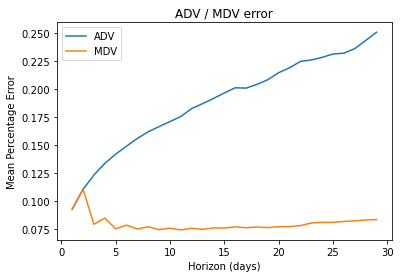

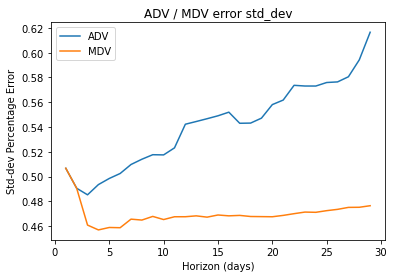

In [108]:
# Plot error for ADV and MDV metrics over the horizons

plt.plot(err["window"], err[["adv_mu", "mdv_mu"]])
plt.title("ADV / MDV error")
plt.xlabel("Horizon (days)")
plt.ylabel("Mean Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

plt.plot(err["window"], err[["adv_sig", "mdv_sig"]])
plt.title("ADV / MDV error std_dev")
plt.xlabel("Horizon (days)")
plt.ylabel("Std-dev Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

## Analysis

1. We can see that MDV average error appears hit a minimum between 5-15 day horizon (at ~7%) then starts to slowly diverge to converge. ADV diverges aggressively with increasing horizon, likely this is due to outliers adversely affecting ADV (longer horizon's increase likelihood window contains an outlier).
2. The std-dev error hits it's minimum MDV at around 5 days (at ~47%). ADV std-dev error diverges more aggressively but with a similar minimum for horizon

This simple analysis supports use of $MDV(5)$ as a reasonable statistic for use in steps 2 & 3

## Step 2: ARMA model

The ARMA model is defined as:

$\hat{V}_t = \bar{V}_{t-1} . D_t + \hat{\beta} . e_{t-1}$

Where:

$\hat{V}_t$ = forecast volume on day t

$\bar{V}_{t-1}$ = $MDV(5)$ selected base volume metric from Step 1.

$D_w$ = day of week adjustment metric

$e_{t-1}$ = Previous days forecast error ($V_{t-1} - \hat{V}_{t-1}$)

$\hat{\beta}$ = Auto-regressive sensitivity parameter - esimated by OLS regression

Rationale is as follows:

1. We use a stable measure of contemporary historical volume $MDV(5)$ on which to base our estimate
2. We believe weekly trade volume is cyclical (weekly) thus add another variable here to adjust $MDV(5)$ on this basis
2. We add an auto-regressive term to capture persistent excess volume across days


### Calculating $D_w$

Our goal here is to determine what (if any) cyclical relationships there are across weekdays.

1. Calculate the deviation of daily trading volumes from their (lagged) weekly average across stocks
2. Average across stocks for each day

We see that there is a hump mid-week with the lowest volume day being Monday. This profile reflects the comments in the text discussing the dip in volume on Friday (one that was not present further back in time).

In [109]:
# calculate cyclical week day volumes (use training set)
# TODO - could use full data set here?

calendar = pd.to_datetime(train_volume.index).isocalendar()
week_keys = calendar.year * 100 + calendar.week

date_week = train_volume.copy()
date_week["week_key"] = week_keys
date_week = date_week["week_key"].reset_index()

week_volume = train_volume.copy()
week_volume["week_key"] = week_keys
week_volume = week_volume.groupby("week_key", as_index=False).mean()
week_volume = date_week.merge(week_volume, how="left", left_on="week_key", right_on="week_key").set_index("date").drop("week_key", axis=1)

pct_volume = train_volume / week_volume
weekday_pct_volume = pct_volume.groupby([calendar.day]).mean().mean(axis=1)

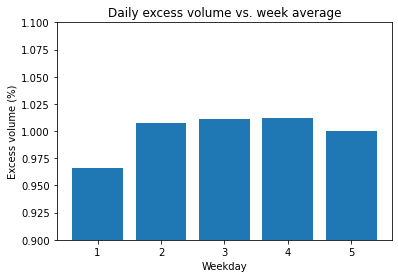

In [110]:
plt.bar(weekday_pct_volume.index, weekday_pct_volume.values)
plt.ylim([0.9, 1.1])
plt.title("Daily excess volume vs. week average") 
plt.ylabel("Excess volume (%)")
plt.xlabel("Weekday")
plt.show()

## Fit the ARMA model

Our objective is to model an auto-regressive term to improve predictive power on $MDV(5)$. We postulate that there is an AR(1) relationship between the error from weekday adjusted median daily volume ($MDV_tw$). We model the percentage difference day on day in order to handle different liquidities / volume across the sample

$e_t = \alpha + \beta . e_{t-1}$

where

$e_t = \frac{\hat{V}_t - MDV_{tw}}{MDV_{tw}}$


We aim to predict:

$\hat{V_t} = MDV_{tw} . (1 + \hat{e_t}) = MDV_{tw . (1 + \alpha + \beta . e_{t-1})$

$MDV_{tw} = MDV_t(5) . D_w$

Note: $MDV_t(5)$ is the rolling median over the 5 days **preceding** $t$

First we look at the distribution of residuals on lagged errors ($e_t - e_{t-1}
$)

1. We notice that error residuals are resonably symmetric (with median of ~-1%)
2. There are several outliers with huge residuals (6000-8000%)
3. Winsorizing outliers at 1% and 99% provides a max absolute residual of ~200%. We are well aware of outlier volume days and this seems like a reasonable level to model normal behaviour

Note: This does not remove the need to address outliers explicitly

In [111]:
def adj_mdv(vol: pd.DataFrame, wd_pct_volume: pd.Series) -> pd.DataFrame():
    """
    Prepare adjusted MDV
    """
    mdv_5 = MDV(vol, 5)
    weekdays = pd.DataFrame(index=mdv_5.index, data={"weekday":mdv_5.index.isocalendar().day})
    mdv_5 = mdv_5.join(weekdays.astype(int))
    mdv_5["weekday"] = mdv_5["weekday"].replace(wd_pct_volume)
    mdv_5 = mdv_5.rename(columns={"weekday": "D_w"})
    adj_mdv_5 = mdv_5.multiply(mdv_5["D_w"], axis=0).drop("D_w", axis=1)
    return adj_mdv_5

In [152]:
# calculate errors
train_adj_mdv_5 = adj_mdv(train_volume, weekday_pct_volume)
train_errs = (train_volume - train_adj_mdv_5) / train_adj_mdv_5
#train_errs = train_volume - train_adj_mdv_5
train_errs_lag = train_errs.shift()

train_errs = train_errs.to_numpy().flatten()
train_errs_lag = train_errs_lag.to_numpy().flatten()
train_mask = ~(np.isnan(train_errs) | np.isnan(train_errs_lag))
train_errs = train_errs[train_mask]
train_errs_lag = train_errs_lag[train_mask]
train_err_df = pd.DataFrame(data={"e_t": train_errs, "e_t-1": train_errs_lag})

e_t descriptive statistics


count    1246560.00
mean          -0.00
std            9.91
min        -6718.61
25%           -0.28
50%           -0.01
75%            0.27
max         8601.53
dtype: float64

,percentile,value
0,0.00,-6718.610863
1,0.01,-1.860427
2,0.02,-1.359629
3,0.03,-1.131284
4,0.04,-0.986925
5,0.05,-0.884774
6,0.95,0.891400
7,0.96,0.995322
8,0.97,1.143547
9,0.98,1.381291


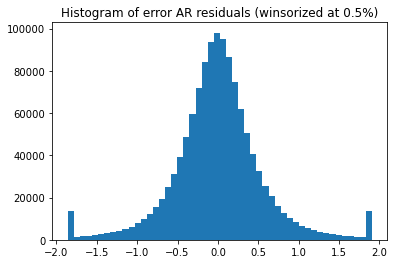

In [153]:
# analyze the error diffs
train_err_AR = train_err_df["e_t"] - train_err_df["e_t-1"]

print("e_t descriptive statistics")
display(train_err_AR.describe().round(2))

# plt.hist(train_err_AR, bins=50, log=True)
# plt.title("Histogram of error AR residuals")
# plt.show()

percentile = list(np.arange(0.0, 0.051, 0.01)) + list(np.arange(0.95, 1.001, 0.01))
percentile_df = pd.DataFrame(data={"percentile": percentile, "value": np.quantile(train_err_AR, percentile)})

display(percentile_df)

train_err_AR_win = winsorize(train_err_AR, 0.01)

plt.hist(train_err_AR_win, bins=50, log=False)
plt.title("Histogram of error AR residuals (winsorized at 0.5%)")
plt.show()

# plt.scatter(np.log(train_errs), np.log(train_errs_lag))
# plt.title("Lagged error percentage scatter")
# plt.xlabel("e_t")
# plt.ylabel("e_t-1")
# plt.show()

train_err_df_censored = train_err_df.copy()
train_err_df_censored["diff"] = train_err_df["e_t"] - train_err_df["e_t-1"]
censored_mask = (train_err_df_censored < train_err_df_censored["diff"].quantile(0.995)) & (train_err_df_censored > train_err_df_censored["diff"].quantile(0.005))
train_err_df_censored = train_err_df_censored[censored_mask]

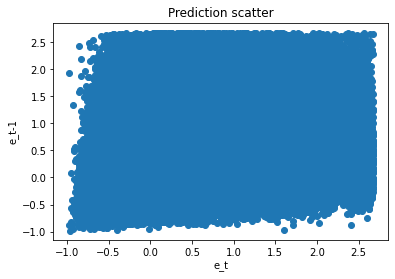

In [154]:
plt.scatter(train_err_df_censored["e_t"], train_err_df_censored["e_t-1"])
plt.title("Prediction scatter")
plt.xlabel("e_t")
plt.ylabel("e_t-1")
plt.show()

We have high in sample coefficient of determiniation $R^2$ = 0.10755115054650133, alpha=0.0510106319699831, beta=0.3252917883690791

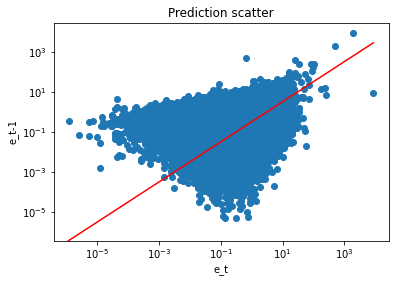

In [155]:
# fit the model

# train_adj_mdv_5_vals = train_adj_mdv_5.to_numpy().flatten()
# train_volume_vals = train_volume.to_numpy().flatten()

# nan_mask = ~(np.isnan(train_adj_mdv_5_vals) | np.isnan(train_volume_vals))

# log_train_adj_mdv_5_vals = np.log(train_adj_mdv_5_vals[nan_mask].reshape(-1, 1))
# log_train_volume_vals = np.log(train_volume_vals[nan_mask].reshape(-1, 1))

# model = LinearRegression()
# model.fit(log_train_adj_mdv_5_vals, log_train_volume_vals)
# train_r_2 = model.score(log_train_adj_mdv_5_vals, log_train_volume_vals)

# display(md(f"We have high in sample coefficient of determiniation $R^2$ = {r_2}"))



# train_err_vals = train_errs.to_numpy().flatten()
# train_err_lag_vals = train_errs_lag.to_numpy().flatten()

train_err_vals = train_err_df_censored["e_t"].to_numpy().flatten()
train_err_lag_vals = train_err_df_censored["e_t-1"].to_numpy().flatten()

nan_mask = ~(np.isnan(train_err_vals) | np.isnan(train_err_lag_vals))

train_err_vals = train_err_vals[nan_mask].reshape(-1, 1)
train_err_lag_vals = train_err_lag_vals[nan_mask].reshape(-1, 1)

# train_err_vals = np.log(train_err_vals)
# train_err_lag_vals = np.log(train_err_lag_vals)

model = LinearRegression()
model.fit(train_err_lag_vals, train_err_vals)
train_r_2 = model.score(train_err_lag_vals, train_err_vals)

alpha = model.intercept_[0]
beta = model.coef_[0][0]

display(md(f"We have high in sample coefficient of determiniation $R^2$ = {train_r_2}, alpha={alpha}, beta={beta}"))


plt.scatter(train_errs, train_errs_lag)
plt.title("Prediction scatter")
plt.ylabel("e_t-1")
plt.xlabel("e_t")
plt.yscale("log")
plt.xscale("log")
pred_x = [train_errs.min().min(), train_errs.max().max()]
pred_y = [alpha + x * beta for x in pred_x]
plt.plot(pred_x, pred_y, '-r', label='y=2x+1')
plt.show()


## Out of sample 

In [224]:
test_adj_mdv_5 = adj_mdv(test_volume, weekday_pct_volume)
test_errs = (test_volume - test_adj_mdv_5) / test_adj_mdv_5
test_errs_lag = test_errs.shift()

test_adj_mdv_5_vals = test_adj_mdv_5.to_numpy().flatten()
test_errs_vals = test_errs.to_numpy().flatten()
test_errs_lag_vals = test_errs_lag.to_numpy().flatten()
test_volume_vals = test_volume.to_numpy().flatten()

nan_mask = ~(np.isnan(test_errs_lag_vals) | np.isnan(test_volume_vals))

test_adj_mdv_5_vals = test_adj_mdv_5_vals[nan_mask]
test_errs_vals = test_errs_vals[nan_mask]
test_errs_lag_vals = test_errs_lag_vals[nan_mask]
test_volume_vals = test_volume_vals[nan_mask]

test_errs_df = pd.DataFrame(data={"e_t":test_errs_vals, "e_t-1":test_errs_lag_vals, "abs_error": abs(test_errs_vals - test_errs_lag_vals)})
test_errs_df_quantile = np.quantile(test_errs_df["abs_error"], 0.95)

# filter outliers
test_errs_df = test_errs_df[test_errs_df["abs_error"] < test_errs_df_quantile]

# plt.scatter(test_errs_df["e_t"], test_errs_df["e_t-1"])
# plt.title("Prediction scatter")
# plt.xlabel("e_t")
# plt.ylabel("e_t-1")

# x = np.array([0, max(test_errs_df["e_t"])])
# y = (model.coef_*x + model.intercept_)[0]

# print(x)
# print(y)

# plt.plot(x, y, '-r', label='fit')
plt.show()


# we use relative volume measures for analysis given liquidity range of universe
eval_metrics = collections.defaultdict(list)

# ARMA MODEL

err_pred = model.predict(test_errs_lag_vals.reshape(-1, 1)).flatten()

y_pred = test_adj_mdv_5_vals * (1 + err_pred)
y_true = test_volume_vals

pct_err = (y_pred - y_true) / y_true
quantile = np.quantile(pct_err, 1.0)

preds = pd.DataFrame(data={"y_true": y_true, "y_pred": y_pred, "error": y_pred - y_true})
threshold_quantile = np.quantile(preds["error"], 0.95)

# filter outliers
preds = preds[preds["error"] < threshold_quantile]

y_pred = preds["y_pred"]
y_true = preds["y_true"]


# Regression metrics
MSLE=metrics.mean_squared_log_error(y_true, y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_true, y_pred)
R2=metrics.r2_score(y_true, y_pred)

eval_metrics["MODEL"].append("ARMA")
eval_metrics["R2"].append(R2)
eval_metrics["MSLE"].append(MSLE)
eval_metrics["MAPE"].append(MAPE)


# ADJ MDV(5) MODEL

y_pred = test_adj_mdv_5_vals
y_true = test_volume_vals

pct_err = (y_pred - y_true) / y_true
quantile = np.quantile(pct_err, 1.0)

preds = pd.DataFrame(data={"y_true": y_true, "y_pred": y_pred, "error": y_pred - y_true})
threshold_quantile = np.quantile(preds["error"], 0.95)

# filter outliers
preds = preds[preds["error"] < threshold_quantile]

y_pred = preds["y_pred"]
y_true = preds["y_true"]


# Regression metrics
MSLE=metrics.mean_squared_log_error(y_true, y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_true, y_pred)
R2=metrics.r2_score(y_true, y_pred)

eval_metrics["MODEL"].append("ADJ MDV(5)")
eval_metrics["R2"].append(R2)
eval_metrics["MSLE"].append(MSLE)
eval_metrics["MAPE"].append(MAPE)

# ADV(30) MODEL

test_adv_30 = ADV(test_volume, 30)
test_adv_30_vals = test_adv_30.to_numpy().flatten()
test_volume_vals = test_volume.to_numpy().flatten()

nan_mask = ~(np.isnan(test_adv_30_vals) | np.isnan(test_volume_vals))

test_adv_30_vals = test_adv_30_vals[nan_mask]
test_volume_vals = test_volume_vals[nan_mask]

y_pred = test_adv_30_vals
y_true = test_volume_vals

pct_err = (y_pred - y_true) / y_true
quantile = np.quantile(pct_err, 1.0)

preds = pd.DataFrame(data={"y_true": y_true, "y_pred": y_pred, "error": y_pred - y_true})
threshold_quantile = np.quantile(preds["error"], 0.95)

# filter outliers
preds = preds[preds["error"] < threshold_quantile]

y_pred = preds["y_pred"]
y_true = preds["y_true"]


# Regression metrics
MSLE=metrics.mean_squared_log_error(y_true, y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_true, y_pred)
R2=metrics.r2_score(y_true, y_pred)

eval_metrics["MODEL"].append("ADV(30)")
eval_metrics["R2"].append(R2)
eval_metrics["MSLE"].append(MSLE)
eval_metrics["MAPE"].append(MAPE)

display(pd.DataFrame(data=eval_metrics))


# print('r2: ', round(R2,4))
# print('MSLE: ', round(MSLE,4))
# print('MAPE: ', round(MAPE,4))

md("""
Metrics used:

R^2 to quantify fit to our clipped data

MSLE (mean squared log error) - applies to targets that scale logarithmically (volumes across universe of stocks). Penalizes under estimates more than over estimates

MAPE (median absolute percentage error) - normalized across universe given percentage measure (these are the natural units for interacting with volume)
""")

,MODEL,R2,MSLE,MAPE
0,ARMA,0.862714,0.139178,0.304618
1,ADJ MDV(5),0.829547,0.162758,0.299961
2,ADV(30),0.819449,0.183330,0.368766



Metrics used:

R^2 to quantify fit to our clipped data

MSLE (mean squared log error) - applies to targets that scale logarithmically (volumes across universe of stocks). Penalizes under estimates more than over estimates

MAPE (median absolute percentage error) - normalized across universe given percentage measure (these are the natural units for interacting with volume)


# Conclusion

Three models are considered ADV30 ADJUSTEDMDV5 and the ARMA model

We can see from the metrics above that, as expected, each level complication provides a better level of fit (the only exception being MAPE outperformance for MDV(5)

The obvious omission in this study is the handling of outliers, we remove the top 5% of volumes as they completly skew test results. This issue combined with the inherent difference in scale of volumes across our universe are why we have chosen relative performance metrics...

In reality we need to handle high volume days (of more concern whentrading on these days) as such follow up tasks would be investigation of how to handle these